In [0]:
import pandas as pd
import numpy as np
from datetime  import datetime  
from datetime import timedelta  
import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.lightgbm
import seaborn as sns

In [0]:
data_location = '../00_data/sample_submission.csv'
submission = pd.read_csv(data_location)

In [0]:
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective':  'tweedie',
        'n_jobs': -1,
        'seed': 0,
        'learning_rate': 0.05, 
        'bagging_fraction': 0.9,
        'bagging_freq': 1, 
        'colsample_bytree': 0.75,
        'num_iterations': 5000,
        'early_stopping_round': 500,
        'max_bin': 100,
        'boost_from_average': False}

In [0]:
data_location = '../04_submissions/best_submission.csv'
best_submission = pd.read_csv(data_location)
best_sumbission_mod = pd.read_csv(data_location)

In [0]:
evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation_rows = [row for row in submission['id'] if 'validation' in row] 
validation_csv = submission[submission['id'].isin(validation_rows)]


In [0]:
i = 'smooth'
X_val = pd.read_pickle("../01_preprocessed_data/X_val_{}.pkl".format(i))
X_val.columns

not_features = ['id', 'd', 'date', 'start_date', 'demand_type', 'demand',  'lag_36', 'lag_37',
       'lag_38', 'lag_39', 'lag_40', 'lag_41']
X_val.columns[~X_val.columns.isin(not_features) ]

Index(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'weekday',
       'month', 'event_name_1', 'event_type_1', 'year', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'days_from_start',
       'start_date_from_start', 'sell_price', 'lag_28', 'lag_29', 'lag_30',
       'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'rmean_28_3',
       'rmean_28_7', 'ADI', 'CV2', 'avg_price', 'avg_demand', 'max_demand',
       'std_demand', 'avg_weekday_demand', 'quantile025_week',
       'max_weekday_demand', 'cheaper_than_usual'],
      dtype='object')

In [0]:
len(X_val.columns[~X_val.columns.isin(not_features) ])

38

In [0]:
validation = pd.DataFrame(columns=submission.columns)
val_score = {'smooth':0, 'erratic':0, 'lumpy':0, 'intermittent':0}
for i in ['intermittent', 'smooth', 'erratic', 'lumpy']:
    print(i)
    X_val = pd.read_pickle("../01_preprocessed_data/X_val_{}.pkl".format(i))
    X_test = pd.read_pickle("../01_preprocessed_data/X_test_{}.pkl".format(i))
    X_train = pd.read_pickle("../01_preprocessed_data/X_train_{}.pkl".format(i))
    y_train = X_train['demand']
    y_val = X_val['demand']
    print(X_train.shape)
    #if i == 'intermittent':
    #    X_train = X_train[X_train['date'] >= '2014-01-01']
    #    y_train = X_train[X_train['date'] >= '2014-01-01']['demand']
    features = X_train.columns[~X_train.columns.isin(not_features) ]

    train_set = lgb.Dataset(X_train[features],y_train)
    val_set = lgb.Dataset(X_val[features], y_val)
    model = lgb.train(params, train_set, valid_sets = [train_set, val_set], verbose_eval = 100)
    
    val_pred = model.predict(X_val[features])
    val_score[i] = metrics.mean_absolute_error(val_pred, y_val)
    print(f'Our val mae score is {val_score[i]}')

    y_test = model.predict(X_test[features])
    X_test['demand'] = y_test
    predictions = X_test[['id', 'days_from_start', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'days_from_start', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(j + 1) for j in range(28)]
    validation = validation.append(submission[['id']].merge(predictions, on = 'id'))

    

intermittent
(32061790, 44)


C:\Users\omore\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\omore\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [0]:
val_score

{'smooth': 2.553143651762391,
 'erratic': 2.901533420631825,
 'lumpy': 1.480857480647582,
 'intermittent': 0.6911376002798957}

In [0]:
val_score

{'smooth': 2.543347095350487,
 'erratic': 2.8938553361298194,
 'lumpy': 1.4975136973640437,
 'intermittent': 0.6948085890245432}

In [0]:
val_score

{'smooth': 2.651268826561964,
 'erratic': 3.0905871546123884,
 'lumpy': 1.5274156949926245,
 'intermittent': 0.6964586970354275}

smooth
erratic
lumpy
intermittent


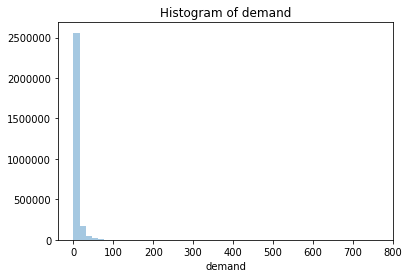

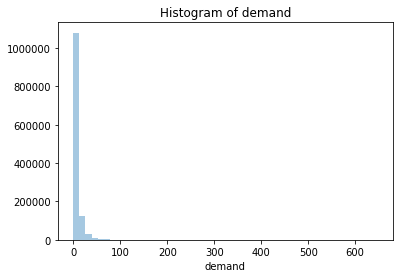

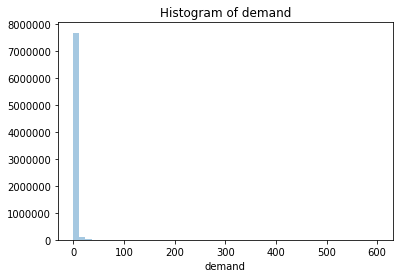

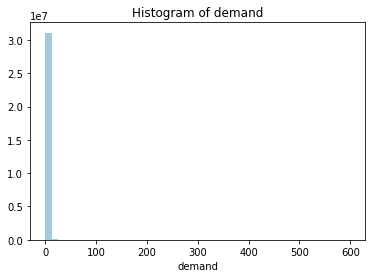

In [0]:
j = 0
for i in ['smooth', 'erratic', 'lumpy', 'intermittent']:
    print(i)
    y_train = pd.read_pickle("../01_preprocessed_data/y_{}_train.pkl".format(i))
    plt.figure(j)
    demand_hist = sns.distplot(y_train, kde=False)
    demand_hist.set_title('Histogram of demand')
    demand_hist.set_xlabel('demand')
    j = j + 1

In [0]:
validation = validation.set_index('id')
validation = validation.reindex(index=validation_csv['id'])
validation = validation.reset_index()

In [0]:
validation

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.742367,0.866123,0.562924,0.516060,0.617936,0.907774,0.683467,0.552344,0.767133,...,0.675261,1.111645,0.881077,0.715126,0.829243,0.564792,0.545139,0.690575,1.044281,0.809680
1,HOBBIES_1_002_CA_1_validation,0.274127,0.272221,0.280583,0.330515,0.336746,0.423590,0.353426,0.246484,0.248716,...,0.203067,0.271706,0.217136,0.154791,0.155858,0.217124,0.254081,0.259896,0.344774,0.272701
2,HOBBIES_1_003_CA_1_validation,0.250126,0.273816,0.258641,0.294966,0.316012,0.484901,0.360427,0.255152,0.287538,...,0.440376,0.737967,0.489905,0.370727,0.418394,0.397389,0.437354,0.537558,0.906960,0.559259
3,HOBBIES_1_004_CA_1_validation,1.697810,1.309548,1.219239,1.457898,1.653466,2.578175,3.097805,1.488469,1.303520,...,1.524364,2.297804,3.172446,1.541021,1.201684,1.116342,1.452004,1.640646,2.920290,3.359145
4,HOBBIES_1_005_CA_1_validation,0.874245,0.748776,0.996890,1.073368,1.161301,1.568719,1.734198,1.035009,0.947323,...,1.071607,1.527152,1.440484,0.813595,0.767593,0.902763,0.916436,1.103348,1.610277,1.751039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.283373,0.242380,0.244147,0.233175,0.263623,0.283307,0.354268,0.354175,0.304919,...,0.430851,0.456957,0.584202,0.392307,0.329572,0.326820,0.346456,0.386274,0.390473,0.524639
30486,FOODS_3_824_WI_3_validation,0.259945,0.192317,0.208371,0.197475,0.199538,0.299577,0.437155,0.488863,0.386800,...,0.387151,0.423677,0.555555,0.360695,0.301338,0.322546,0.308395,0.305652,0.318711,0.393425
30487,FOODS_3_825_WI_3_validation,0.955071,0.682186,0.632661,0.585083,0.634786,0.813533,0.883363,1.081762,0.931017,...,1.096983,1.389704,1.407895,1.111789,0.827663,0.740170,0.707077,0.821973,0.953954,0.899340
30488,FOODS_3_826_WI_3_validation,1.264444,1.240725,0.867764,0.703409,0.661878,1.000066,1.264763,1.051855,1.345835,...,0.685238,1.115630,1.423551,0.840807,0.920803,0.665715,0.552484,0.595628,0.948256,1.312350


In [0]:
final = pd.concat([validation, evaluation])

In [0]:
X.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'demand', 'date', 'wm_yr_wk', 'weekday', 'month', 'event_name_1',
       'event_type_1', 'year', 'event_name_2', 'event_type_2', 'snap_CA',
       'snap_TX', 'snap_WI', 'start_date', 'days_from_start',
       'start_date_from_start', 'sell_price', 'lag_28', 'lag_29', 'lag_30',
       'lag_31', 'lag_32', 'lag_33', 'lag_34', 'rmean_28_7', 'rmean_28_14'],
      dtype='object')

In [0]:
X[X['id'] == 'FOODS_3_135_WI_2_validation'][['id', 'd',
       'demand', 'date', 'weekday', 'month', 'event_name_1',
       'event_type_1', 'year', 'event_name_2', 'event_type_2', 'snap_CA',
       'snap_TX', 'snap_WI', 'start_date', 'days_from_start',
       'start_date_from_start']]

,id,d,demand,date,weekday,month,event_name_1,event_type_1,year,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,start_date,days_from_start,start_date_from_start
34266192,FOODS_3_135_WI_2_validation,d_1526,0,2015-04-03,Friday,4,no event,no event,2015,no event,no event,1,1,1,2015-02-21,1525,1484
34296234,FOODS_3_135_WI_2_validation,d_1527,0,2015-04-04,Saturday,4,no event,no event,2015,no event,no event,1,0,0,2015-02-21,1526,1484
34326282,FOODS_3_135_WI_2_validation,d_1528,0,2015-04-05,Sunday,4,Easter,Cultural,2015,no event,no event,1,1,1,2015-02-21,1527,1484
34356330,FOODS_3_135_WI_2_validation,d_1529,0,2015-04-06,Monday,4,no event,no event,2015,no event,no event,1,1,1,2015-02-21,1528,1484
34386378,FOODS_3_135_WI_2_validation,d_1530,0,2015-04-07,Tuesday,4,no event,no event,2015,no event,no event,1,1,0,2015-02-21,1529,1484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46755978,FOODS_3_135_WI_2_validation,d_1937,0,2016-05-18,Wednesday,5,no event,no event,2016,no event,no event,0,0,0,2015-02-21,1936,1484
46786468,FOODS_3_135_WI_2_validation,d_1938,0,2016-05-19,Thursday,5,no event,no event,2016,no event,no event,0,0,0,2015-02-21,1937,1484
46816958,FOODS_3_135_WI_2_validation,d_1939,0,2016-05-20,Friday,5,no event,no event,2016,no event,no event,0,0,0,2015-02-21,1938,1484
46847448,FOODS_3_135_WI_2_validation,d_1940,0,2016-05-21,Saturday,5,no event,no event,2016,no event,no event,0,0,0,2015-02-21,1939,1484


In [0]:
data_location = "../01_preprocessed_data/X_lags.pkl"
X = pd.read_pickle(data_location)
X[X['id'] == 'FOODS_3_135_WI_2_validation']


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,sell_price,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,rmean_28_7,rmean_28_14
34266192,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,d_1526,0,2015-04-03,11509,...,1.480469,1.0,5.0,4.0,1.0,1.0,0.0,4.0,2.285156,1.357422
34296234,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,d_1527,0,2015-04-04,11510,...,1.480469,0.0,1.0,5.0,4.0,1.0,1.0,0.0,1.713867,1.357422
34326282,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,d_1528,0,2015-04-05,11510,...,1.480469,0.0,0.0,1.0,5.0,4.0,1.0,1.0,1.713867,1.357422
34356330,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,d_1529,0,2015-04-06,11510,...,1.480469,2.0,0.0,0.0,1.0,5.0,4.0,1.0,1.857422,1.500000
34386378,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,d_1530,0,2015-04-07,11510,...,1.480469,0.0,2.0,0.0,0.0,1.0,5.0,4.0,1.713867,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46755978,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,d_1937,0,2016-05-18,11616,...,1.480469,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.714355,0.428467
46786468,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,d_1938,0,2016-05-19,11616,...,1.480469,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.571289,0.428467
46816958,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,d_1939,0,2016-05-20,11616,...,1.480469,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.142822,0.428467
46847448,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,d_1940,0,2016-05-21,11617,...,1.480469,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285645,0.571289


In [0]:
for i in ['intermittent', 'smooth', 'erratic', 'lumpy']:
    print(i)
    X_val = pd.read_pickle("../01_preprocessed_data/X_val_{}.pkl".format(i))
    X_test = pd.read_pickle("../01_preprocessed_data/X_test_{}.pkl".format(i))
    X_train = pd.read_pickle("../01_preprocessed_data/X_train_{}.pkl".format(i))
    print(X_train[X_train['id'] == 'FOODS_3_135_WI_2_validation'])
    print(X_val[X_val['id'] == 'FOODS_3_135_WI_2_validation'])
    print(X_test[X_test['id'] == 'FOODS_3_135_WI_2_validation'])

intermittent
Empty DataFrame
Columns: [id, item_id, dept_id, cat_id, store_id, state_id, d, demand, date, weekday, month, event_name_1, event_type_1, year, event_name_2, event_type_2, snap_CA, snap_TX, snap_WI, start_date, days_from_start, start_date_from_start, sell_price, lag_28, lag_29, lag_30, lag_31, lag_32, lag_33, lag_34, rmean_28_7, rmean_28_14, ADI, CV2, demand_type, avg_weekday_demand, avg_demand, max_demand, std_demand, quantile025_week, max_weekday_demand, avg_price, cheaper_than_usual]
Index: []

[0 rows x 43 columns]
Empty DataFrame
Columns: [id, item_id, dept_id, cat_id, store_id, state_id, d, demand, date, weekday, month, event_name_1, event_type_1, year, event_name_2, event_type_2, snap_CA, snap_TX, snap_WI, start_date, days_from_start, start_date_from_start, sell_price, lag_28, lag_29, lag_30, lag_31, lag_32, lag_33, lag_34, rmean_28_7, rmean_28_14, ADI, CV2, demand_type, avg_price, avg_demand, max_demand, std_demand, avg_weekday_demand, quantile025_week, max_weekday_

In [0]:
final = final.fillna(0)
final[final['id'] == 'FOODS_3_135_WI_2_validation']


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
26751,FOODS_3_135_WI_2_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
final.to_csv('../04_submissions/submission-by_demand_type_poisson.csv', index = False)

In [0]:
with open("../04_submissions/submission-by_demand_type_poisson.txt", "a") as outfile:
    #outfile.write("\n".join(features))
    #outfile.write("\n")
    outfile.write(str(params) )
    outfile.write("\n")
    #outfile.write(str(val_score))
    #outfile.write("\n")

In [0]:
X_val.groupby(['demand_type'])['demand_type', 'abs_difference'].agg(['mean']).reset_index()

In [0]:
X_val[X_val['demand_type'] == 'smooth'].sort_values(by = 'abs_difference')

In [0]:
data_location = '../04_submissions/best_submission.csv'
best_submission_orig = pd.read_csv(data_location)


In [0]:
best_submission_orig[best_submission_orig['id'].isin(X_test['id'])]

In [0]:
best_submission[best_submission['id'].isin(X_test['id'])]